<a href="https://colab.research.google.com/github/BenWilop/WSG_games/blob/main/playground_WSG_games.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [1]:
import getpass
import dotenv
import wandb
import os
dotenv.load_dotenv(os.path.join('/homes/55/bwilop/wsg/private/', 'vscode-ssh.env'))
api_key = os.getenv('WANDB_API_KEY')
wandb.login(key=api_key)

data_folder = '/homes/55/bwilop/wsg/data/'
experiment_folder = '/homes/55/bwilop/wsg/experiments/'

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /homes/55/bwilop/.netrc
wandb: Currently logged in as: benwilop (benwilop-rwth-aachen-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [2]:
%load_ext autoreload
%autoreload 2
import torch as t
import torch.nn as nn
from torch.nn.functional import cross_entropy, softmax
from torch import Tensor
from jaxtyping import Float
from tqdm import tqdm
from transformer_lens import HookedTransformerConfig, HookedTransformer
import json
from typing import Callable, Any
import einops
import time
import uuid
import glob
from copy import deepcopy
import matplotlib.pyplot as plt
from datetime import datetime
import torch.nn as nn

from wsg_games.tictactoe.evals import *
from wsg_games.tictactoe.data import *
from wsg_games.tictactoe.game import *

from wsg_games.tictactoe.analysis.analyse_data import *
from wsg_games.tictactoe.analysis.visualize_game import *

from wsg_games.tictactoe.train.create_models import *
from wsg_games.tictactoe.train.save_load_models import *
from wsg_games.tictactoe.train.train import *
from wsg_games.tictactoe.train.finetune import *
from wsg_games.tictactoe.train.pretrain import *

device = t.device("cuda" if t.cuda.is_available() else "cpu")
print(device)

cuda


# Data

In [3]:
# tictactoe_data = cache_tictactoe_data(data_folder + 'tictactoe_data.pkl')
tictactoe_data = cache_tictactoe_data_random(data_folder + 'tictactoe_data_random_STRONG_RULE_REVERSE_RULE.pkl')
# tictactoe_data = cache_tictactoe_data_random(data_folder + 'tictactoe_data_random_STRONG_RULE_NO_DIAGONAL.pkl')
print_data_statistics(tictactoe_data)

Shape Data:    torch.Size([200000, 10])
Shape Random:  torch.Size([200000, 10, 10])
Shape Weak:    torch.Size([200000, 10, 10])
Shape Strong:  torch.Size([200000, 10, 10])
--------------------------------------------------------
Evals Random:  {'weak_accuracy': 0.6971979737281799, 'strong_accuracy': 0.6485714912414551, 'illegal_move_chance': 0.0}
Evals Weak:    {'weak_accuracy': 1.0, 'strong_accuracy': 0.5115560293197632, 'illegal_move_chance': 0.0}
Evals Strong:  {'weak_accuracy': 0.5757150053977966, 'strong_accuracy': 1.0, 'illegal_move_chance': 0.0}
--------------------------------------------------------
Entropy Random:  0.8480209708213806
Entropy Weak:    0.3486904203891754
Entropy Strong:  0.4996753931045532
--------------------------------------------------------


In [4]:
# tictactoe_train_data, weak_finetune_data, tictactoe_val_data, tictactoe_test_data = train_test_split_tictactoe(tictactoe_data, 0.5, 0.25, 0.05, 0.20, device, 1234)
tictactoe_train_data, tictactoe_weak_finetune_data, tictactoe_val_data, tictactoe_test_data = train_test_split_tictactoe_first_two_moves_no_overlap(tictactoe_data, 42, 15, 5, 10, device, 1234)

print("Shape Train: ", tictactoe_train_data.games_data.shape)
print("Shape Weak Finetune: ", tictactoe_weak_finetune_data.games_data.shape)
print("Shape Validation: ", tictactoe_val_data.games_data.shape)
print("Shape Test:  ", tictactoe_test_data.games_data.shape)

Shape Train:  torch.Size([116742, 10])
Shape Weak Finetune:  torch.Size([41581, 10])
Shape Validation:  torch.Size([13938, 10])
Shape Test:   torch.Size([27739, 10])


In [5]:
leakage_pct = calculate_leakage_percentage(tictactoe_train_data, tictactoe_test_data)
print(f"Leakage Percentage: {leakage_pct:.2f}%")

Leakage Percentage: 0.00%


In [6]:
# plot_train_test_prefix_histograms(tictactoe_train_data, tictactoe_test_data)

In [7]:
import torch.nn.functional as F

def sample_hard_labels_from_soft(soft_labels: t.Tensor, num_samples) -> t.Tensor:
    n_games, game_length, n_tokens = soft_labels.shape
    soft_labels_flat = soft_labels.view(-1, n_tokens)
    sampled_indices = t.multinomial(soft_labels_flat, num_samples=num_samples, replacement=True)

    one_hot_samples = F.one_hot(sampled_indices, num_classes=n_tokens).float()
    one_hot_samples = one_hot_samples.view(n_games, game_length, num_samples, n_tokens)
    one_hot_samples = one_hot_samples.permute(0, 2, 1, 3)
    new_hard_labels = one_hot_samples.reshape(n_games * num_samples, game_length, n_tokens)
    return new_hard_labels

def create_hard_label_tictactoe_data(data: TicTacToeData, num_samples, random_seed: int = 4567) -> TicTacToeData:
    """
    Samples for weak and strong goal one fixed trajectory.
    The random samples stay the same to make it easier to check for illegal moves.
    """
    t.manual_seed(random_seed)
    new_games_data = data.games_data.repeat_interleave(num_samples, dim=0)
    new_weak_goals_labels  = sample_hard_labels_from_soft(data.weak_goals_labels, num_samples=num_samples)
    new_strong_goals_labels = sample_hard_labels_from_soft(data.strong_goals_labels, num_samples=num_samples)
    return TicTacToeData(
        games_data=new_games_data,
        random_move_labels=data.random_move_labels,
        weak_goals_labels=new_weak_goals_labels,
        strong_goals_labels=new_strong_goals_labels
    )

tictactoe_train_data = create_hard_label_tictactoe_data(tictactoe_train_data, num_samples=1)
tictactoe_weak_finetune_data = create_hard_label_tictactoe_data(tictactoe_weak_finetune_data, num_samples=1)
tictactoe_val_data = create_hard_label_tictactoe_data(tictactoe_val_data, num_samples=1)

In [8]:
print("Shape Train: ", tictactoe_train_data.games_data.shape)
tictactoe_train_data.weak_goals_labels[0][:3]

Shape Train:  torch.Size([116742, 10])


tensor([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]], device='cuda:0')

In [9]:
print("Shape Weak Finetune: ", tictactoe_weak_finetune_data.games_data.shape)
tictactoe_weak_finetune_data.weak_goals_labels[0][:3]

Shape Weak Finetune:  torch.Size([41581, 10])


tensor([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]], device='cuda:0')

In [10]:
print("Shape Val: ", tictactoe_val_data.games_data.shape)
tictactoe_val_data.weak_goals_labels[0][:3]

Shape Val:  torch.Size([13938, 10])


tensor([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]], device='cuda:0')

In [11]:
print("Shape Test:  ", tictactoe_test_data.games_data.shape)
tictactoe_test_data.weak_goals_labels[0][:3]

Shape Test:   torch.Size([27739, 10])


tensor([[0.1111, 0.1111, 0.1111, 0.1111, 0.1111, 0.1111, 0.1111, 0.1111, 0.1111,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.3333, 0.3333, 0.0000, 0.3333,
         0.0000]], device='cuda:0')

# Train model

In [12]:
# raise Exception()

### Parameters

In [13]:
training_cfg = {
    "learning_rate": 1e-3, # 1e-4,
    "weight_decay": 1e-4,  # 1e-5,
    "max_epochs": 1000,
    "early_stopping_patience": 3,
    "batch_size": 64,
}

model_sizes = {}
model_sizes["nano"]   = {"n_layers": 1, "n_heads": 1, "d_model": 1, "d_head": 1, "d_mlp": 4}
model_sizes["micro"]   = {"n_layers": 1, "n_heads": 2, "d_model": 4, "d_head": 2, "d_mlp": 16}
model_sizes["mini"]   = {"n_layers": 2, "n_heads": 4, "d_model": 8, "d_head": 2, "d_mlp": 32}

model_sizes["small"] = {"n_layers": 3, "n_heads": 4, "d_model": 16, "d_head": 4, "d_mlp": 64}
model_sizes["medium"] = {"n_layers": 4, "n_heads": 8, "d_model": 32, "d_head": 4, "d_mlp": 128}
model_sizes["large"] = {"n_layers": 5, "n_heads": 8, "d_model": 64, "d_head": 8, "d_mlp": 256}

model_sizes["huge"]   = {"n_layers": 6, "n_heads": 16, "d_model": 128, "d_head": 8,  "d_mlp": 512}
# model_sizes["gigantic"] = {"n_layers": 7, "n_heads": 16, "d_model": 256, "d_head": 16, "d_mlp": 1024}

# model_size_to_epochs = {
#                 # roughly converged after
#     "nano": 3,  # 1
#     "micro": 20,  # 10
#     "mini": 40,  # 20
#     "small": 50,  # 35
#     "medium": 4,  # 2
#     "large": 2,  # 1
#     # "huge": 1,
#     # "gigantic": 1
# }


def get_model_config(size: str):
    common_params = {
        "act_fn": "relu",
        "normalization_type": "LN",
        "d_vocab": 11,
        "d_vocab_out": 10,
        "n_ctx": 10,
        "init_weights": True,
        "device": "cuda",
        "seed": 1337,
    }
    specific = model_sizes[size]
    return HookedTransformerConfig(**specific, **common_params)

print_model_ratios(model_sizes, get_model_config)

Moving model to device:  cuda
nano 6.8 * 10^01
Moving model to device:  cuda
micro 3.9 * 10^02
Moving model to device:  cuda
mini 2.0 * 10^03
Moving model to device:  cuda
small 1.0 * 10^04
Moving model to device:  cuda
medium 5.2 * 10^04
Moving model to device:  cuda
large 2.5 * 10^05
Moving model to device:  cuda
huge 1.2 * 10^06
Ratio of consecutive model-sizes:  [5.676470588235294, 5.227979274611399, 5.142715559960357, 4.9992291385623435, 4.857985428472302, 4.736774029725204]


### wandb

### Train loop

In [14]:
from wsg_games.tictactoe.evals import *
from wsg_games.tictactoe.data import *
from wsg_games.tictactoe.game import *

from wsg_games.tictactoe.analysis.analyse_data import *
from wsg_games.tictactoe.analysis.visualize_game import *

from wsg_games.tictactoe.train.create_models import *
from wsg_games.tictactoe.train.save_load_models import *
from wsg_games.tictactoe.train.train import *
from wsg_games.tictactoe.train.finetune import *
from wsg_games.tictactoe.train.pretrain import *

In [15]:
# project_name = "tictactoe_playground"
# model_size = "large"
# model_cfg = get_model_config(model_size)
# wandb.finish()
# model, _, _ = run_full_training(project_name, model_size, Goal.STRONG_GOAL, tictactoe_train_data, tictactoe_val_data, tictactoe_test_data, training_cfg, model_cfg)

### Experiments

In [16]:
project_name = "tictactoe_pretrained_reverse_rule_no_overlap_split_start_third_200k"
# project_name = "tictactoe_pretrained_forbidden_diagonals_no_overlap_split_start_third_200k"
# pretrain_models(experiment_folder, project_name, tictactoe_train_data, tictactoe_val_data, tictactoe_test_data, training_cfg, get_model_config)

Loading model from /homes/55/bwilop/wsg/experiments//tictactoe_pretrained_reverse_rule_no_overlap_split_start_third_200k/experiment_nano_weak_2025-03-17-11-01_l0yq7mf2.pkl
Moving model to device:  cpu
Loading model from /homes/55/bwilop/wsg/experiments//tictactoe_pretrained_reverse_rule_no_overlap_split_start_third_200k/experiment_nano_strong_2025-03-17-11-03_qsmciq80.pkl
Moving model to device:  cpu
Loading model from /homes/55/bwilop/wsg/experiments//tictactoe_pretrained_reverse_rule_no_overlap_split_start_third_200k/experiment_micro_weak_2025-03-17-11-05_c0ud9wk2.pkl
Moving model to device:  cpu
Loading model from /homes/55/bwilop/wsg/experiments//tictactoe_pretrained_reverse_rule_no_overlap_split_start_third_200k/experiment_micro_strong_2025-03-17-11-10_lcifn598.pkl
Moving model to device:  cpu
Loading model from /homes/55/bwilop/wsg/experiments//tictactoe_pretrained_reverse_rule_no_overlap_split_start_third_200k/experiment_mini_weak_2025-03-17-11-15_gp6nbh3i.pkl
Moving model to de

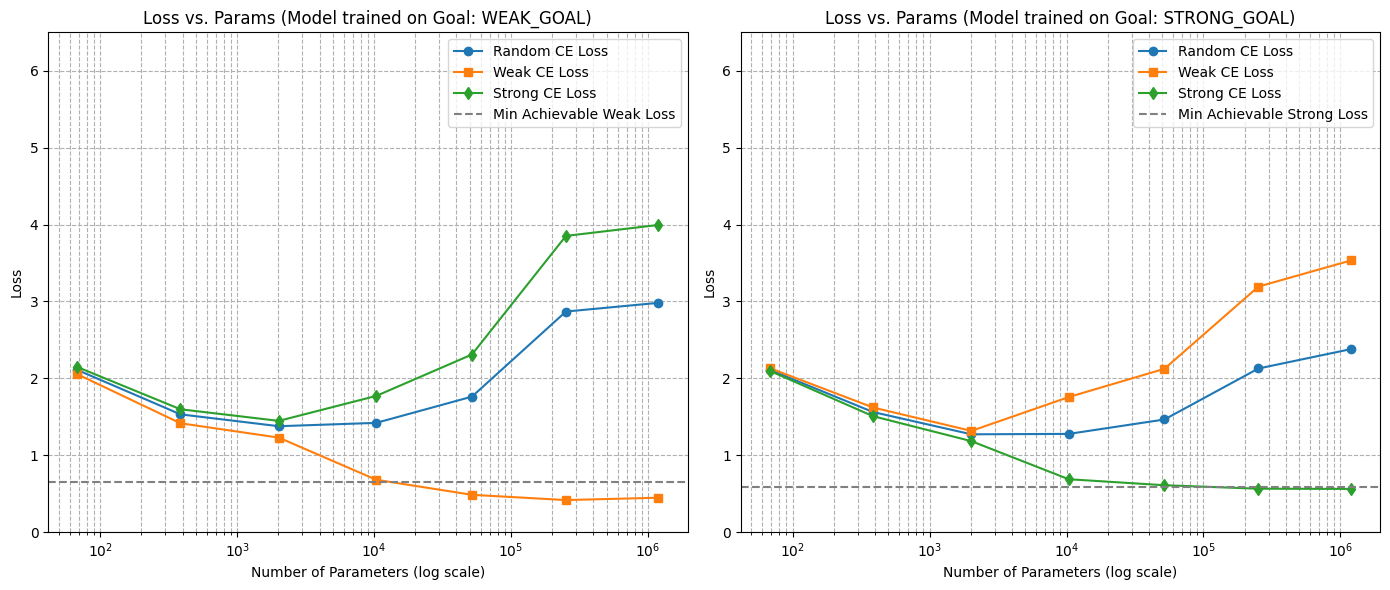

In [17]:
plot_loss_pretrain_models(experiment_folder, project_name, tictactoe_test_data)

In [18]:
# project_name = "tictactoe_pretrained_reverse_rule_no_overlap_split_start_third_200k"
# weak_model_weak_goals = load_model(project_name, "mini", Goal.WEAK_GOAL, experiment_folder)
# strong_model_weak_goals = load_model(project_name, "medium", Goal.WEAK_GOAL, experiment_folder)
# strong_model_strong_goals = load_model(project_name, "medium", Goal.STRONG_GOAL, experiment_folder)
# quick_evaluation("Weak model weak goal", weak_model_weak_goals, tictactoe_test_data)
# quick_evaluation("Strong model weak goal", strong_model_weak_goals, tictactoe_test_data)
# quick_evaluation("Strong model strong goal", strong_model_strong_goals, tictactoe_test_data)
# strong_model_finetuned = deepcopy(strong_model_strong_goals)

# project_name = "tictactoe_playground"
# timestamp = datetime.now().strftime("%Y-%m-%d-%H-%M")
# experiment_name = f"experiment_finetuning_{timestamp}"
# # Use validation data as weak_train_data
# finetune_strong_with_weak(project_name, experiment_name, weak_model_weak_goals, strong_model_finetuned, tictactoe_weak_finetune_data, tictactoe_test_data, adapted_training_cfg)

In [ ]:
pretrained_project_name = "tictactoe_pretrained_reverse_rule_no_overlap_split_start_third_200k" 
finetuned_project_name = "finetune_sweep_test"
finetune_sweep(pretrained_project_name, finetuned_project_name, experiment_folder, tictactoe_weak_finetune_data, tictactoe_val_data, tictactoe_test_data, training_cfg)

Loading model from /homes/55/bwilop/wsg/experiments//tictactoe_pretrained_reverse_rule_no_overlap_split_start_third_200k/experiment_mini_weak_2025-03-17-11-15_gp6nbh3i.pkl
Loading model from /homes/55/bwilop/wsg/experiments//tictactoe_pretrained_reverse_rule_no_overlap_split_start_third_200k/experiment_medium_strong_2025-03-17-12-00_j80ppnzs.pkl
Finetuning: weak model (mini) -> strong model (medium)


Training epochs:   0%|          | 0/1000 [00:00<?, ?it/s]

Training batches:   0%|          | 0/650 [00:00<?, ?it/s]

Training batches:   0%|          | 0/650 [00:00<?, ?it/s]

KeyboardInterrupt: 

# Inspect model

In [ ]:
project_name = "tictactoe_pretrained_reverse_rule_no_overlap_split_start_third_200k"
model = load_model(project_name, "large", Goal.STRONG_GOAL, experiment_folder)
quick_evaluation("model weak goal", model, tictactoe_test_data)

Loading model from /homes/55/bwilop/wsg/experiments//tictactoe_pretrained_reverse_rule_no_overlap_split_start_third_200k/experiment_large_strong_2025-03-17-12-30_3z524rtf.pkl
model weak goal
weak_loss:  3.2204160690307617
strong_loss:  0.563201367855072


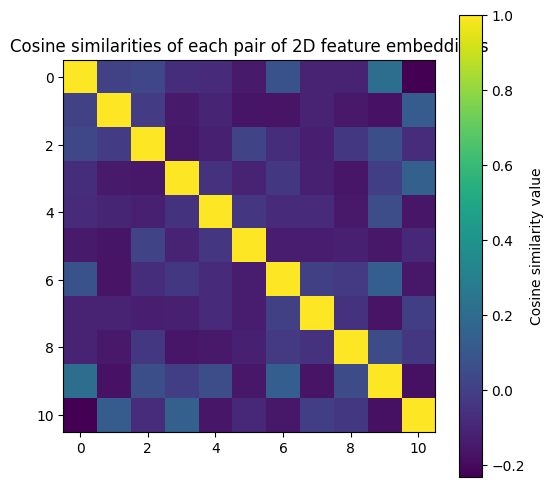

In [ ]:
W = model.embed.W_E
W_normed = W / W.norm(dim=1, keepdim=True)

# Compute cosine similarity matrix and move to CPU as a NumPy array
cosine_sim = (W_normed @ W_normed.T).detach().cpu().numpy()

im = plt.imshow(cosine_sim)
plt.title("Cosine similarities of each pair of 2D feature embeddings")
plt.gcf().set_size_inches(6, 6)

# Add a colorbar with a label
cbar = plt.colorbar(im)
cbar.set_label("Cosine similarity value")

plt.show()

In [ ]:
W.shape

torch.Size([11, 64])

In [ ]:
train_sample = random_sample_tictactoe_data(tictactoe_train_data, 1)
train_logits = model(train_sample.games_data)
soft_labels = softmax(train_logits, dim=-1)
hard_labels = F.one_hot(train_sample.weak_goals_labels.argmax(dim=-1), num_classes=train_logits.shape[-1]).float()

print(train_sample.weak_goals_labels.shape)
print(train_logits.shape)
print(soft_labels.shape)
print(hard_labels.shape)

torch.Size([1, 10, 10])
torch.Size([1, 10, 10])
torch.Size([1, 10, 10])
torch.Size([1, 10, 10])


In [ ]:
train_sample.weak_goals_labels

tensor([[[0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
         [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
         [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]]], device='cuda:0')

In [ ]:
soft_labels.clip(0.01)

tensor([[[0.1036, 0.1301, 0.1165, 0.1214, 0.1077, 0.1125, 0.1046, 0.1104,
          0.0932, 0.0100],
         [0.0100, 0.0100, 0.0100, 0.0100, 0.9999, 0.0100, 0.0100, 0.0100,
          0.0100, 0.0100],
         [0.2764, 0.0100, 0.0100, 0.0100, 0.3568, 0.0100, 0.0100, 0.0100,
          0.3648, 0.0100],
         [0.9994, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100,
          0.0100, 0.0100],
         [0.9990, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100,
          0.0100, 0.0100],
         [0.9996, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100,
          0.0100, 0.0100],
         [0.4368, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100,
          0.5604, 0.0100],
         [0.9997, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100,
          0.0100, 0.0100],
         [0.9998, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100,
          0.0100, 0.0100],
         [0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100,
          0.0100,

In [ ]:
hard_labels

tensor([[[0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
         [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
         [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]]], device='cuda:0')

In [ ]:
board = Board()
print(get_best_moves(board, Goal.WEAK_GOAL))
board.make_move(1)
print(get_best_moves(board, Goal.WEAK_GOAL))

[0, 1, 2, 3, 4, 5, 6, 7, 8]
[0, 2, 4, 7]


In [ ]:
tictactoe_test_data.games_data[600]

tensor([10,  4,  1,  8,  7,  2,  3,  0,  9,  9], device='cuda:0')

In [ ]:
tictactoe_test_data.weak_goals_labels[2]

tensor([[0.1111, 0.1111, 0.1111, 0.1111, 0.1111, 0.1111, 0.1111, 0.1111, 0.1111,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.3333, 0.3333, 0.0000, 0.3333,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.5000, 0.5000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.2500, 0.2500, 0.0000, 0.2500, 0.2500,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.2500, 0.0000, 0.2500, 0.2500, 0.2500,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.5000, 0.5000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         1.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         1.0000]], device='c

In [ ]:
tictactoe_test_data.games_data[25][:]

tensor([10,  4,  1,  0,  2,  6,  8,  7,  5,  9], device='cuda:0')

In [ ]:
softmax(model(tictactoe_test_data.games_data[25][:]), dim=-1).clip(0.01)

tensor([[[0.1036, 0.1301, 0.1165, 0.1214, 0.1077, 0.1125, 0.1046, 0.1104,
          0.0932, 0.0100],
         [0.1916, 0.0100, 0.2943, 0.0100, 0.0100, 0.0100, 0.3077, 0.0100,
          0.2052, 0.0100],
         [0.1249, 0.0144, 0.1796, 0.1968, 0.0100, 0.1214, 0.1726, 0.0551,
          0.1326, 0.0100],
         [0.0100, 0.0100, 0.1544, 0.1765, 0.0100, 0.1364, 0.1932, 0.2096,
          0.1215, 0.0100],
         [0.0100, 0.0100, 0.0100, 0.2537, 0.0109, 0.2465, 0.2858, 0.0100,
          0.1956, 0.0100],
         [0.0100, 0.0100, 0.0109, 0.2432, 0.0100, 0.3787, 0.0100, 0.1257,
          0.2400, 0.0100],
         [0.0100, 0.0100, 0.0100, 0.9924, 0.0100, 0.0100, 0.0100, 0.0100,
          0.0100, 0.0100],
         [0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.9876, 0.0100, 0.0100,
          0.0100, 0.0100],
         [0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100,
          0.0100, 1.0000],
         [0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100,
          0.0100,

In [ ]:
skip_to = 0
train_dataset = TensorDataset(
    tictactoe_train_data.games_data,
    tictactoe_train_data.random_move_labels,
    tictactoe_train_data.weak_goals_labels,
    tictactoe_train_data.strong_goals_labels,
)
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=False)
i = 0
for games, random_labels, weak_labels, strong_labels in train_loader:
    logits = model(games)
    probs = torch.softmax(logits, dim=-1)
    illegal_mask = (random_labels == 0).float()
    illegal_move_probs = (probs * illegal_mask).sum(dim=-1)
    avg_illegal = illegal_move_probs.mean().item()

    print(i, avg_illegal)

    i += 1
    if i > 100:
        break

0 0.00047798408195376396
1 0.00037515017902478576
2 0.0002354414900764823
3 0.00046389372437261045
4 0.00048006614088080823
5 0.00043550608097575605
6 7.49953105696477e-05
7 0.0004786814679391682
8 0.00042770575964823365
9 0.00023153229267336428
10 0.00017442960233893245
11 0.0009913687827065587
12 0.00011239608284085989
13 0.00042853024206124246
14 7.67340388847515e-05
15 3.400661444175057e-05
16 0.0006997838499955833
17 0.0019308017799630761
18 0.0012453497620299459
19 0.0012593267019838095
20 0.0004908811533823609
21 0.0001961621455848217
22 0.00026389077538624406
23 0.0009204309317283332
24 0.002569131786003709
25 0.0003627234837040305
26 0.00018834318325389177
27 0.0006549917161464691
28 6.928086077095941e-05
29 0.0018002905417233706
30 0.00013082408986520022
31 0.0027316813357174397
32 0.0004050150455441326
33 0.0006105154170654714
34 0.0005172835662961006
35 0.00042033797944895923
36 5.5117339798016474e-05
37 0.0023260186426341534
38 9.577766468282789e-05
39 0.000241994115640409

tensor([10,  2,  0,  4,  8,  5,  7,  3,  9,  9], device='cuda:0')


/homes/55/bwilop/wsg/WSG_games/wsg_games/tictactoe/analysis/visualize_game.py:77: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.93, 1])


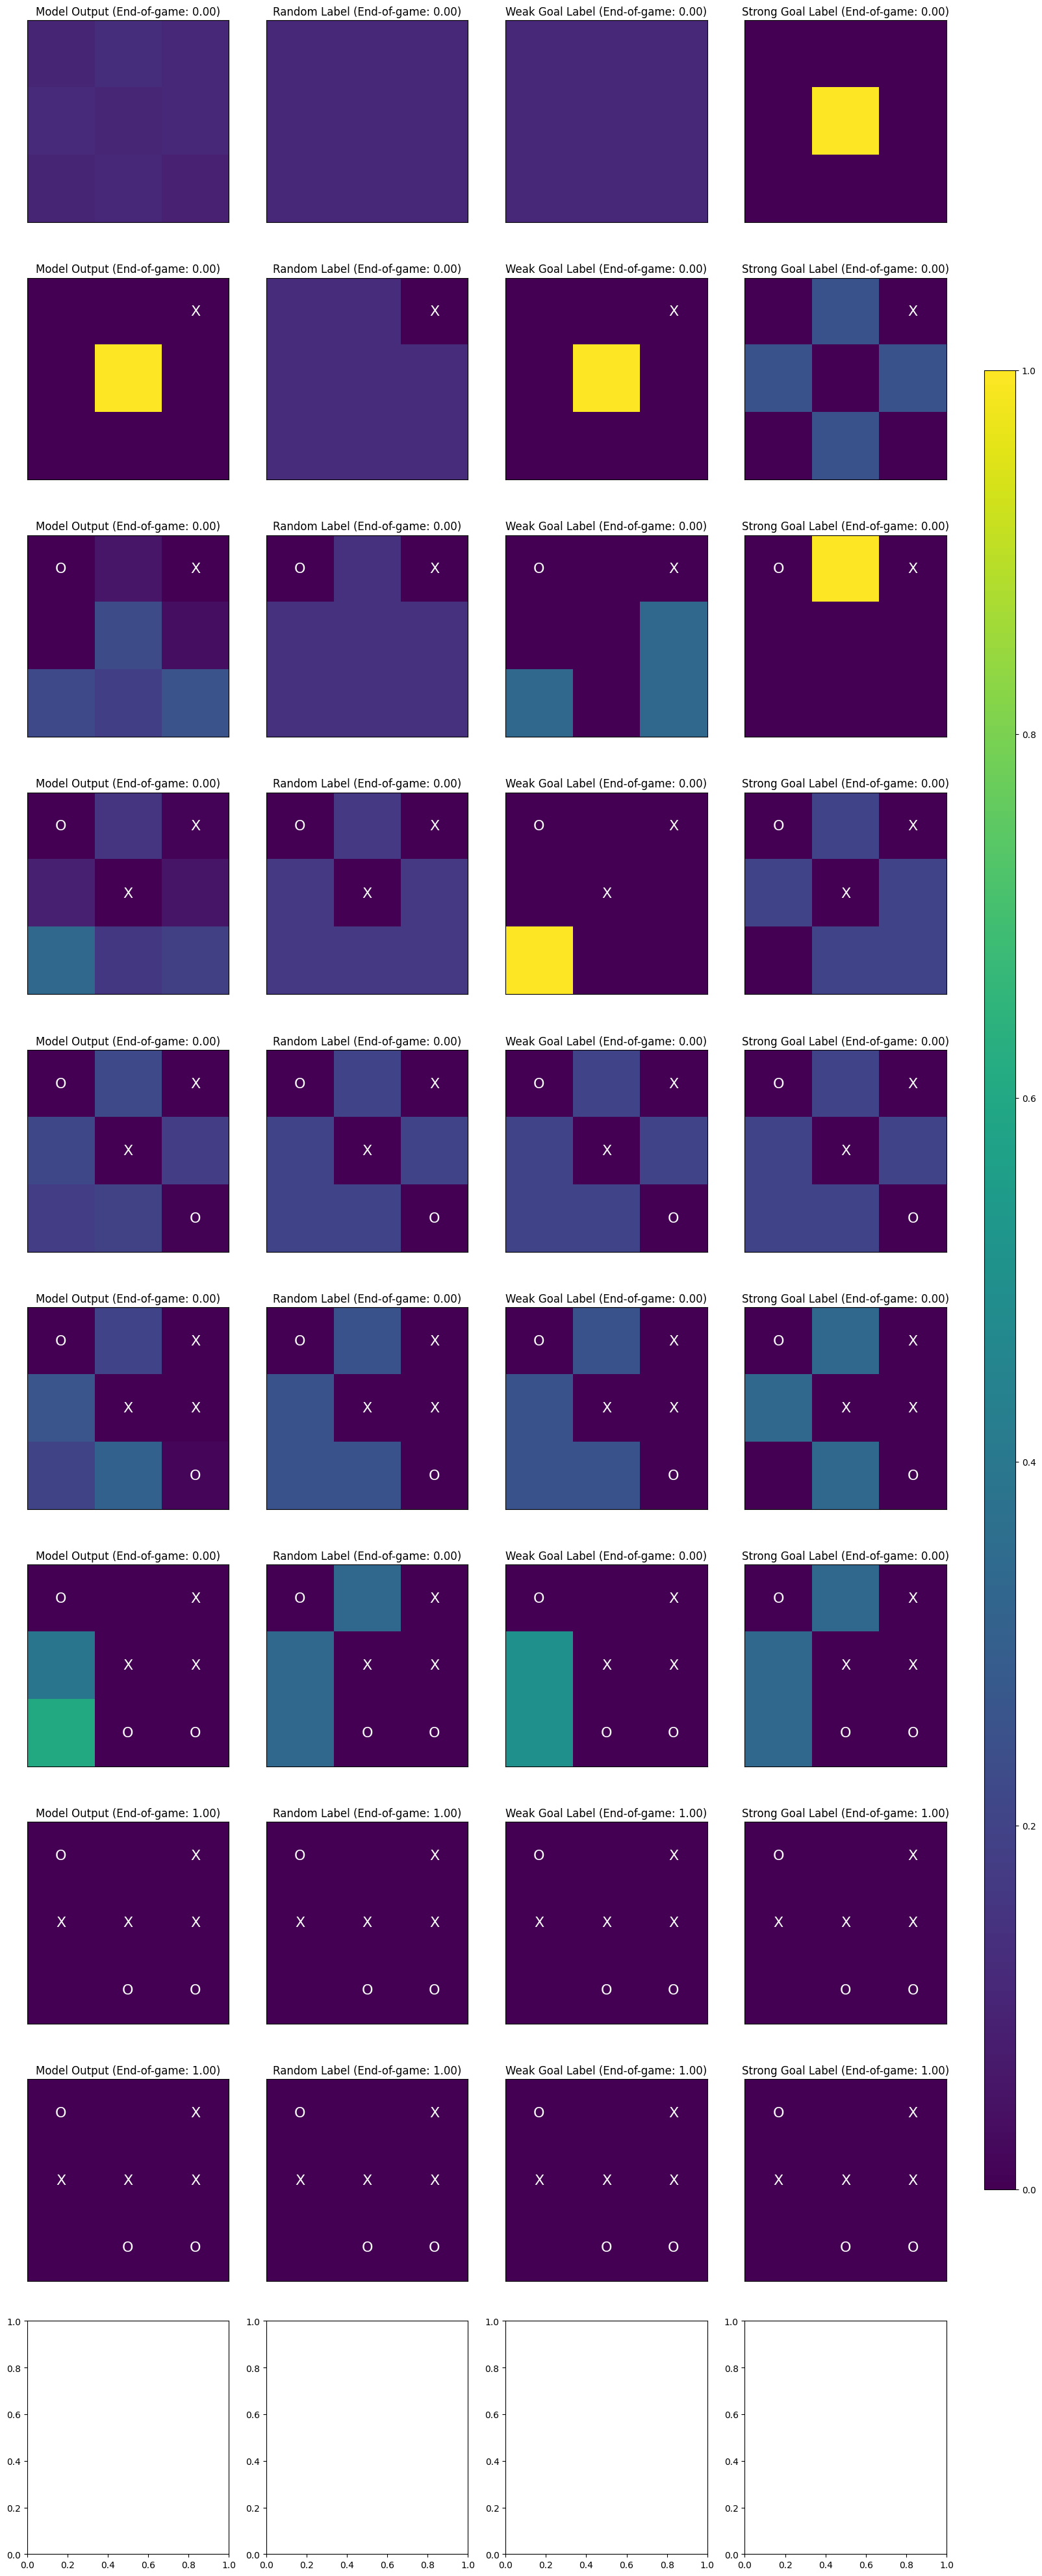

In [ ]:
visualize_game(tictactoe_test_data, game_id=0, model=model)

# Sample games

In [ ]:
samples = sample_games(model, 1, 100)

In [ ]:
evals.eval_model(samples)

NameError: name 'evals' is not defined

In [ ]:
sample = samples[1]
print(sample)

In [ ]:
from alphatoe.game import Board, State

def check(game: list[int]) -> bool:
    board = Board()
    for move in game[1:-1]:
        print(move)
        if board.game_state == State.ONGOING:
            try:
                board.make_move(move)
            except:
                return True
        elif move == 9:
            pass
        else:
            return True
    return False

check(sample)

In [ ]:
game.play_game(sample)
print("\nPLAY:")
board = game.Board()
for move in sample:
  if move not in [9, 10]:
    board.make_move(move)
    board.draw_board()
    print(".")

In [ ]:
print(evals.model_vs_minimax(model, True), "\n")
print(evals._check_minimax_win_rate(model, 100))

In [ ]:
evals.get_error_rate(samples)